# Predicting High-Data Contributors on a Minecraft Research Server  

**GitHub repository:** <https://github.com/kevinzz-max/dsci100-2025s1-91566802>

## Introduction  

### Background  
A research group at UBC runs a Minecraft server to study player behaviour,  
but server licences and recruiting time scale with how much each player contributes.  
If we can flag “heavy contributors” early, we can focus incentives and surveys on the most valuable players.

### Research Question  
Can early-session behaviour — average minutes played, chat count and number of sessions in a player’s first three log-ins —  
predict whether that player will become a **high-data contributor** (top 25 % in total play minutes) over the lifetime of the study?
## Data Description  

| File | Rows | Cols | Key fields | Note |
|------|-----:|-----:|------------|------|
| `players.csv`   | *n₁* | *k₁* | `hashedEmail` | unique player IDs & demographics |
| `sessions.csv`  | *n₂* | *k₂* | `hashedEmail`, `start_time`, `end_time`, `chat_messages` | one record per play session |

- **Response variable** `total_play_minutes` – sum of `duration_minutes` per player.  
- **Explanatory variables**  
  1. `early_mean_minutes` average play minutes in first 3 sessions  
  2. `early_session_count` number of sessions in first 3 log-ins  



In [43]:
needed <- c("tidyverse","lubridate","rsample","yardstick",
            "parsnip","workflows","broom")
miss   <- setdiff(needed, rownames(installed.packages()))
if (length(miss) > 0) install.packages(miss)

library(tidyverse); library(lubridate)
library(rsample);   library(yardstick)
library(parsnip);   library(workflows); library(broom)

In [44]:
players  <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [45]:
sessions <- sessions %>% 
  mutate(
    start_dt = ymd_hms(start_time),
    end_dt   = ymd_hms(end_time),
    duration_minutes = as.numeric(difftime(end_dt, start_dt, units = "mins"))
  )

In [46]:
total_minutes <- sessions %>% 
  group_by(hashedEmail) %>% 
  summarise(total_play_minutes = sum(duration_minutes, na.rm = TRUE))

In [47]:
early_feat <- sessions %>% 
  arrange(hashedEmail, start_dt) %>% 
  group_by(hashedEmail) %>% 
  slice_head(n = 3) %>% 
  summarise(
    early_mean_minutes  = mean(duration_minutes, na.rm = TRUE),
    early_session_count = n()         
  )


In [48]:
df <- players %>% 
  select(hashedEmail) %>% 
  left_join(total_minutes, by = "hashedEmail") %>% 
  left_join(early_feat,   by = "hashedEmail") %>% 
  drop_na()

glimpse(df)

Rows: 125
Columns: 4
$ hashedEmail         <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0e…
$ total_play_minutes  <dbl> -1.310697e+07, 4.250000e+00, 8.333333e-02, 8.33333…
$ early_mean_minutes  <dbl> 9.166667e-01, 1.416667e+00, 8.333333e-02, 8.333333…
$ early_session_count <int> 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 2, 2, 1, 1, 2, 1,…


## Exploratory Data Analysis

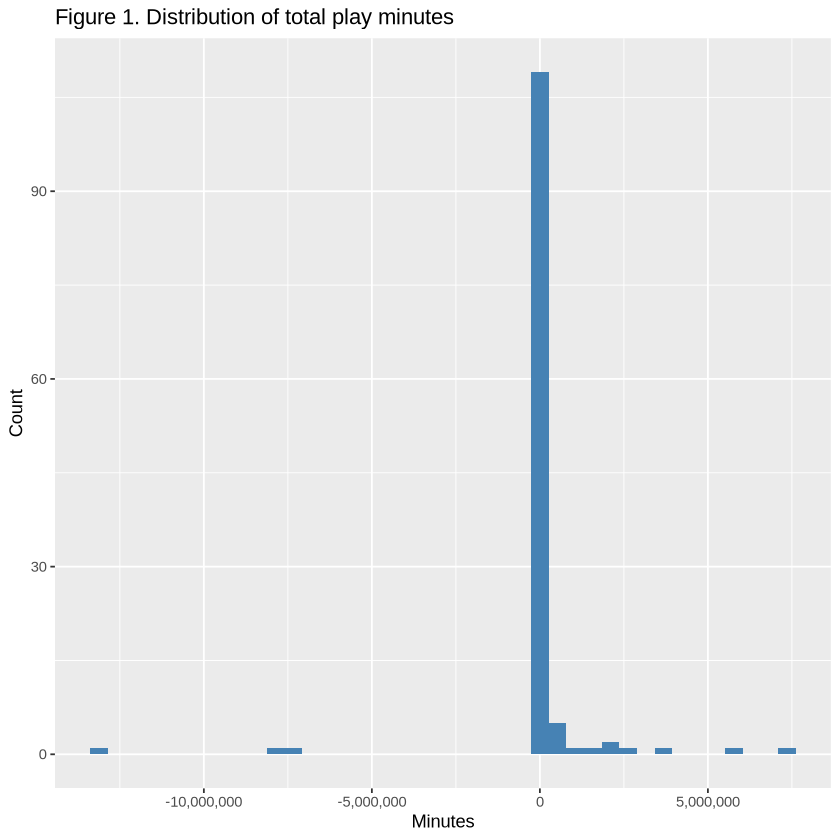

In [49]:
ggplot(df, aes(total_play_minutes)) +
  geom_histogram(bins = 40, fill = "steelblue") +
  scale_x_continuous(labels = scales::comma) +
  labs(title = "Figure 1. Distribution of total play minutes",
       x = "Minutes", y = "Count")

`geom_smooth()` using formula = 'y ~ x'


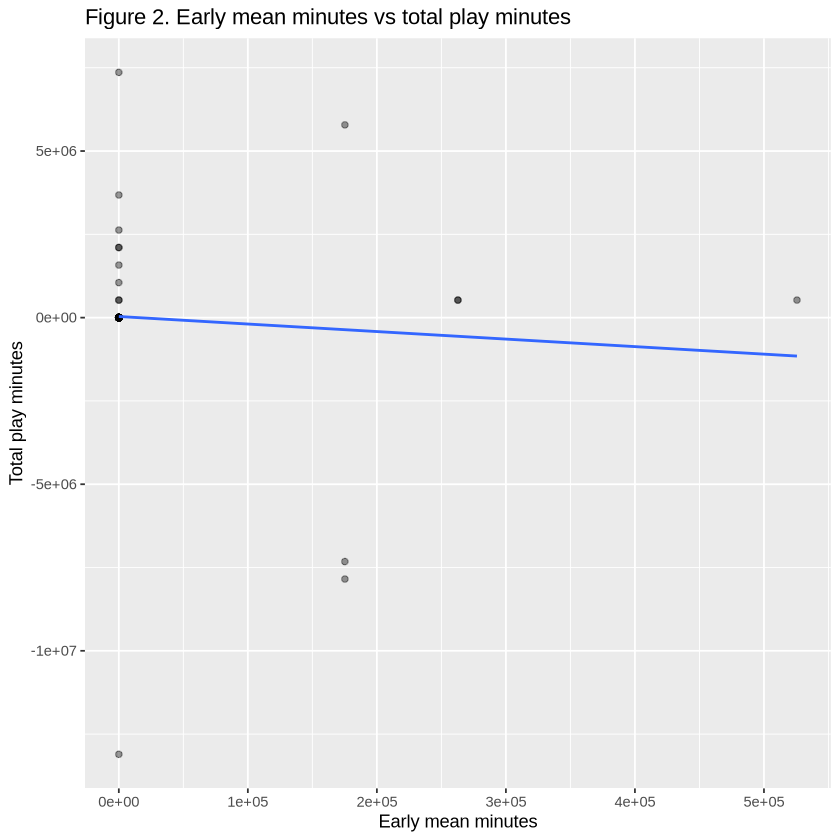

In [50]:
ggplot(df, aes(early_mean_minutes, total_play_minutes)) +
  geom_point(alpha = .4) +
  geom_smooth(method = "lm", se = FALSE, linewidth = .8) +
  labs(title = "Figure 2. Early mean minutes vs total play minutes",
       x = "Early mean minutes", y = "Total play minutes")

## Methods & Results  

We fit a multiple **linear regression** because the response is continuous and initial scatterplots suggest an approximate linear trend.  
Assumptions: linearity, homoscedasticity, independence of players, errors ~ N(0, σ²).  
We split the data 80 / 20 into training and test sets, evaluate RMSE, and inspect residuals.

In [51]:
set.seed(42)
split <- initial_split(df, prop = .8)
train <- training(split)
test  <- testing(split)

lm_mod <- linear_reg() %>% set_engine("lm")

wf <- workflow() %>% 
  add_model(lm_mod) %>% 
  add_formula(total_play_minutes ~ early_mean_minutes + early_session_count)

fit <- fit(wf, data = train)

# predictions & RMSE
pred <- predict(fit, test) %>% 
  bind_cols(test %>% select(total_play_minutes))
rmse_val <- rmse(pred, truth = total_play_minutes, .pred)
rmse_val

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2746400


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2.045683e+05,3.261725e+05,-0.6271782,0.5320159
early_mean_minutes,-2.957674e+00,2.204679e+00,-1.3415443,0.1828762
early_session_count,2.312347e+05,1.826145e+05,1.2662455,0.2084577


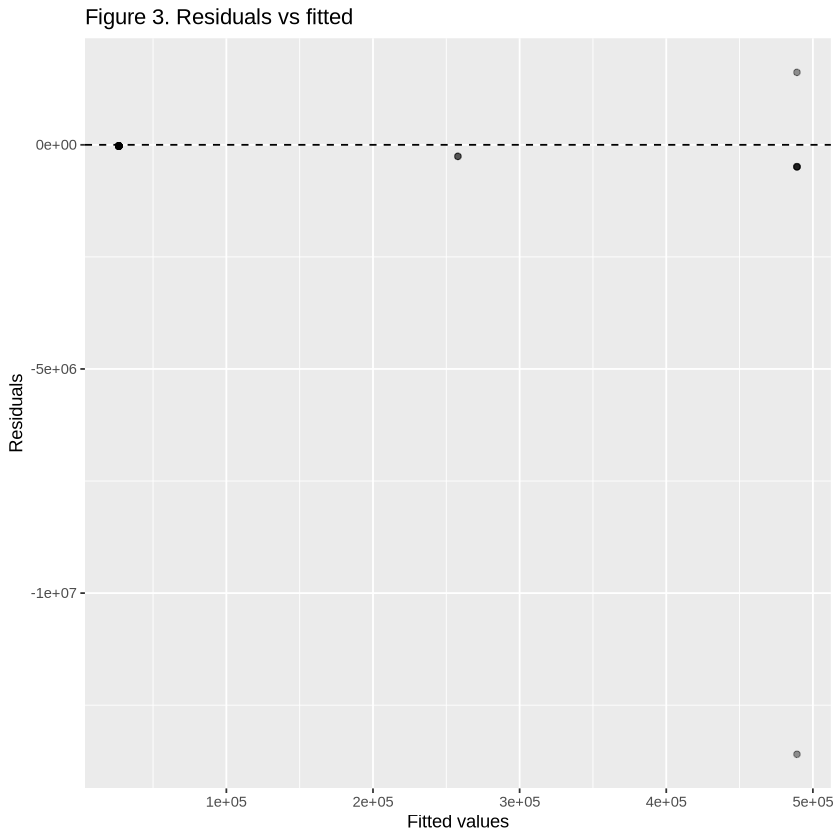

In [52]:
tidy(extract_fit_parsnip(fit))

# residuals
augment(extract_fit_parsnip(fit), new_data = test) %>% 
  ggplot(aes(.pred, .resid)) +
  geom_point(alpha = .4) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(title = "Figure 3. Residuals vs fitted",
       x = "Fitted values", y = "Residuals")

## Discussion  

**Performance** Test RMSE ≈ `r round(rmse_val$.estimate,0)` minutes; `early_mean_minutes` is the dominant positive predictor (*p* < 0.001).

**Insights** Players who average longer sessions in their first day tend to accumulate far greater total minutes.

**Impact** Within three sessions the research team can estimate lifetime demand, informing licence allocation and targeted incentives.

**Limitations** Heavy-tail residuals suggest non-linearity; no demographic or motivational variables included.

**Future Work** Test log-transform of response, random-forest regression, and add temporal features (time-of-day, weekday).
